In [2]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm, trange
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import euclidean, cityblock
from sklearn.base import clone
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.neighbors import NearestNeighbors
from pyclustering.cluster.kmedoids import kmedoids
from scipy.cluster.hierarchy import dendrogram, fcluster
from fastcluster import linkage

from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, confusion_matrix
from DBCV import DBCV

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, confusion_matrix


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kqyrf0xc because the default path (/home/calbao/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
[nltk_data] Downloading package punkt to
[nltk_data]     /home/msds2023/calbao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/msds2023/calbao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
conn = sqlite3.connect('/mnt/processed/private/msds2023/lt9/dmw2_final_project.db')
df = (pd.read_sql("""SELECT * FROM partners""", conn)
      .query('protected==0', engine='python')
      .reset_index(drop=True)
      .drop(columns=['url', 'included'])
     )

In [43]:
# PRE-PROCESSING DF FOR CLUSTERING

# define tagalog stop words and bad words [R]
tl_stopwords = ["pldt", "pldtcares", "pldthome", "akin", "aking", "ako", "alin",
                "am", "amin", "aming", "ang", "ano", "anumang", "apat", "at", "atin",
                "ating", "ay", "bababa", "bago", "bakit", "bawat", "bilang", "dahil",
                "dalawa", "dapat", "din", "dito", "doon", "gagawin", "gayunman",
                "ginagawa", "ginawa", "ginawang", "gumawa", "gusto", "habang",
                "hanggang", "hindi", "huwag", "iba", "ibaba", "ibabaw", "ibig",
                "ikaw", "ilagay", "ilalim", "ilan", "inyong", "isa", "isang",
                "itaas", "ito", "iyo", "iyon", "iyong", "ka", "kahit", "kailangan",
                "kailanman", "kami", "kanila", "kanilang", "kanino", "kanya",
                "kanyang", "kapag", "kapwa", "karamihan", "katiyakan", "katulad",
                "kaya", "kaysa", "ko", "kong", "kulang", "kumuha", "kung", "laban",
                "lahat", "lamang", "likod", "lima", "maaari", "maaaring", "maging",
                "mahusay", "makita", "marami", "marapat", "masyado", "may",
                "mayroon", "mga", "minsan", "mismo", "mula", "muli", "na",
                "nabanggit", "naging", "nagkaroon", "nais", "nakita", "namin",
                "napaka", "narito", "nasaan", "ng", "ngayon", "ni", "nila", "nilang",
                "nito", "niya", "niyang", "noon", "o", "pa", "paano", "pababa",
                "paggawa", "pagitan", "pagkakaroon", "pagkatapos", "palabas",
                "pamamagitan", "panahon", "pangalawa", "para", "paraan", "pareho",
                "pataas", "pero", "pumunta", "pumupunta", "sa", "saan", "sabi",
                "sabihin", "sarili", "sila", "sino", "siya", "tatlo", "tayo",
                "tulad", "tungkol", "una", "walang", "nyo", "niyo", "naman",
                "mo", "pls", "po", "kayo", "ba", "hi", "hello", "wala", "u",
                "nung", "nang", "kami", "kmi", "amp", "beh", "rin", "din",
                "jusko", "ha", "g", "kasi", "lang", "pi", "nadin", "narin",
                "e", "eh", "nga", "hey", "huy", "kayong", "nag", "paki", "pls"]

tl_badwords = ["amputa", "animal ka", "bilat", "binibrocha", "bobo", "bogo",
               "boto", "brocha", "burat", "bwesit", "bwisit", "demonyo ka",
               "engot", "etits", "gaga", "gagi", "gago", "habal", "hayop ka",
               "hayup", "hinampak", "hinayupak", "hindot", "hindutan", "hudas",
               "iniyot", "inutel", "inutil", "iyot", "kagaguhan", "kagang",
               "kantot", "kantotan", "kantut", "kantutan", "kaululan", "kayat",
               "kiki", "kikinginamo", "kingina", "kupal", "leche", "leching",
               "lechugas", "lintik", "nakakaburat", "nimal", "ogag", "olok",
               "pakingshet", "pakshet", "pakyu", "pesteng yawa", "poke", "poki",
               "pokpok", "poyet", "pu'keng", "pucha", "puchanggala", "puchangina",
               "puke", "puki", "pukinangina", "puking", "punyeta", "puta", "putang",
               "putang ina", "putangina", "putanginamo", "putaragis", "putragis",
               "puyet", "ratbu", "shunga", "sira ulo", "siraulo", "suso", "susu",
               "tae", "taena", "tamod", "tanga", "tangina", "taragis", "tarantado",
               "tete", "teti", "timang", "tinil", "tite", "titi", "tungaw", "ulol",
               "ulul", "ungas", "yawa"]

exclude_words = stopwords.words(
    'english') + tl_stopwords + tl_badwords + ['twitter', 'account', 'official', 'new']


def text_remove_unicode(text):
    text = re.sub(
        r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?",
        "", text)
    return text


class Lemmatizer:
    """Lemmatize text using WordNet"""

    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, text):
        return [
            self.wnl.lemmatize(word)
            for word
            in re.findall(r"(?u)(?<!<)[a-z]{2,}", text)
        ]


def df_for_clustering(df, to_drop=True):
    def filter_char(c): return ord(c) < 256
    data = df.copy()
    data['description'] = (data['description'].str.lower()
                           .apply(lambda s: ''.join(filter(filter_char, s)))
                           .apply(text_remove_unicode)
                           .apply(lambda x: " ".join([re.sub('[^A-Za-z]+',
                                                             '', x)
                                                      for x in
                                                      nltk.word_tokenize(
                               x)
                           ]))
                           .apply(lambda x: re.sub(' +', ' ', x))
                           .apply(lambda x: " ".join([x for x in x.split()
                                                      if x not in
                                                      exclude_words
                                                      ]))
                           )
    data['tenure'] = 2023 - pd.to_datetime(data.created_at).dt.year
    data['has_location'] = np.where(data.location.isna(), 0, 1)
    data['follower_ratio'] = data.followers_count/data.following_count
    data['follower_ratio'] = (data.follower_ratio.replace(np.inf, np.nan)
                              .fillna(data.followers_count))

    tfidfvectorizer = TfidfVectorizer(
        token_pattern=None,
        tokenizer=Lemmatizer(),
        stop_words=exclude_words+["u", "im", "dont"],
        max_df=0.7,
        min_df=0.01
    ).fit(data.description)

    data_descrip = pd.DataFrame(
        tfidfvectorizer.transform(data.description).todense(),
        columns=tfidfvectorizer.get_feature_names_out(),
        index=range(1, len(data.description)+1)
    ).reset_index(drop=True)

    final = (pd.concat([data,
                       data_descrip], axis=1)
             .set_index(['id', 'username', 'name']))

    if to_drop:
        final.drop(columns=['followers_count', 'following_count',
                            'description', 'created_at', 'location',
                            'protected'],
                   inplace=True)

    final[['tweet_count',
           'listed_count',
           'tenure',
           'follower_ratio']] = (StandardScaler().fit_transform(
               final[['tweet_count', 'listed_count',
                      'tenure', 'follower_ratio']])
    )

    return final

# DIMENSION REDUCTION


def truncated_svd(X):
    """
    Function that accepts the design matrix and returns q, sigma, p and the 
    normalized sum of squared distance from the origin
    """

    q, s, p = np.linalg.svd(X, full_matrices=False)
    Q = q
    S = np.diag(s)
    P = p.T
    NSSD = (s / np.sqrt(np.sum(s**2)))**2

    return Q, S, P, NSSD


def min_svs(df):
    """
    Function to get the minimum number of Singular Vectors that explain 
    at least 80% of variance
    """
    q, s, p, nssd = truncated_svd(df)
    nssd_cumsum = nssd.cumsum()
    return np.argwhere(nssd_cumsum >= 0.75)[0][0]+1


# K-MEDOIDS

def cluster_range_kmedoids(X, k_start, k_stop, actual=None):
    """
    Function that accepts the design matrix, the initial and final values to 
    step through, and, optionally, actual labels. It returns a dictionary of 
    the cluster labels, cluster centers, internal validation values and, 
    if actual labels is given, external validation values, for every  𝑘 
    """

    ys = []
    cs = []
    inertias = []
    chs = []
    scs = []
    dbs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []

    dist = euclidean
    X = np.asarray(X)

    for k in trange(k_start, k_stop+1):
        clusterer_k = kmedoids(X, np.arange(k), ccore=True)
        clusterer_k.process()
        clusters = clusterer_k.get_clusters()
        y_pred = np.zeros(len(X), dtype=int)
        for cluster, point in enumerate(clusters):
            y_pred[point] = cluster
        centers = X[clusterer_k.get_medoids()]

        ys.append(y_pred)
        cs.append(centers)

        res_dict = dict(zip(['ys', 'centers'], [ys, cs]))

        # internal validation metrics
        sse = np.sum([euclidean(x, c) ** 2 for i, c
                      in enumerate(centers) for x in X[y_pred == i]])
        inertias.append(sse)  # SS to centroids
        chs.append(calinski_harabasz_score(X, y_pred))  # Calinski-Hanbaz
        scs.append(silhouette_score(X, y_pred))  # Sillhouete score
        dbs.append(davies_bouldin_score(X, y_pred))  # Davies-Bouldin

        keys = ['inertias', 'chs', 'scs', 'dbs']
        values = [inertias, chs, scs, dbs]
        internal_dict = dict(zip(keys, values))

    res = {**res_dict, **internal_dict}

    return res


def plot_internal(chs, scs, dbs):
    """Plot internal validation values"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ks = np.arange(2, len(chs)+2)
    axes[0].plot(ks, chs, '-ro', label='CH')
    axes[0].set_xlabel('$k$')
    axes[0].set_ylabel('CH')
    axes[1].plot(ks, scs, '-ko', label='Silhouette coefficient')
    axes[1].set_xlabel('$k$')
    axes[1].set_ylabel('Silhouette')
    axes[2].plot(ks, dbs, '-gs', label='DB')
    axes[2].set_xlabel('$k$')
    axes[2].set_ylabel('DB')
    plt.subplots_adjust(wspace=0.4)
    return axes


def plot_clusters(X, ys, centers, transformer):
    """Plot clusters given the design matrix and cluster labels"""
    k_max = len(ys) + 1
    k_mid = k_max//2 + 2
    fig, ax = plt.subplots(2, k_max//2, dpi=150, sharex=True, sharey=True,
                           figsize=(7, 4),  # subplot_kw=dict(aspect='equal'),
                           gridspec_kw=dict(wspace=0.01))
    for k, y, cs in zip(range(2, k_max+1), ys, centers):
        centroids_new = transformer.transform(cs)
        if k < k_mid:
            ax[0][k % k_mid-2].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[0][k % k_mid-2].scatter(
                centroids_new[:, 0],
                centroids_new[:, 1],
                s=10,
                c=range(int(max(y)) + 1),
                marker='s',
                ec='k',
                lw=1
            )
            ax[0][k % k_mid-2].set_title('$k=%d$' % k)
        else:
            ax[1][k % k_mid].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[1][k % k_mid].scatter(
                centroids_new[:, 0],
                centroids_new[:, 1],
                s=10,
                c=range(int(max(y))+1),
                marker='s',
                ec='k',
                lw=1
            )
            ax[1][k % k_mid].set_title('$k=%d$' % k)
    return ax

def plot_describe_cluster(df, cluster):
    """
    Function that outputs analysis per cluster via wordcloud and radar plots
    """
    import plotly.express as px
    import plotly.graph_objects as go

    dict_clustname = {1: 'News/Entertainment Outlets', 2: 'Celebrities',
                      3: 'Social Media Macro & Micro Influencers'}
    dict_color_radar = {1: '#feae02', 2: '#888888', 3: '#1c43c9'}
    dict_color_cloud = {1: 'Wistia', 2:'gray', 3:'Blues'}

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)

    # Wordcloud
    text = ' '.join([word for word in
                     set(df_final[(df_final.cluster == cluster)]
                         ['description'])
                     if word not in exclude_words])
    mask_img = np.array(Image.open('dove.jpg'))
    wordcloud = WordCloud(background_color='white',
                          collocations=False,
                          mask=mask_img,
                          colormap=dict_color_cloud[cluster]).generate(text)
    ax.imshow(wordcloud, interpolation="bilinear")
    plt.title(
        f'Cluster: {dict_clustname[cluster]}, {df_final[(df_final.cluster == cluster)].shape[0]} Twitter accounts')
    ax.axis('off')
    plt.show()
    
    # Radar Plot

    df_med = (df
              [['followers_count', 'following_count', 'tweet_count',
                  'listed_count', 'tenure', 'cluster']]
              .groupby('cluster').agg('median')
              )
    df_med.iloc[:, :] = MinMaxScaler().fit_transform(df_med)

    categories = df_med.columns.tolist()
    categories = [*categories, categories[0]]

    fig = go.Figure()

    r_ = df_med.iloc[cluster-1].values[0:].tolist()
    r_ = [*r_, r_[0]]
    fig.add_trace(go.Scatterpolar(
        r=r_,
        theta=categories,
        fill='toself',
        name=str(df_med.index[cluster-1]),
        line_color=dict_color_radar[df_med.index[cluster-1]],
        opacity=0.7
    ))

    fig.update_layout(template=None, plot_bgcolor="rgba(0,0,0,0)",
                      paper_bgcolor="rgba(0,0,0,0)",
                      polar=dict(radialaxis=dict(angle=90,
                                                 tick0=1,
                                                 dtick=0.5,
                                                 range=[-1, 1.45],
                                                 tickangle=90,
                                                 titlefont={"size": 15, }),
                                 angularaxis=dict(rotation=162,
                                                  tickfont={"size": 15})),
                      showlegend=False)
    fig.show(config={"editable": True,
                     'toImageButtonOptions': {
                         'format': 'png', 
                         'filename': 'ternary',
                         'scale': 5  
                     }
                     })

In [47]:
df_clean = df_for_clustering(df)
display(df_clean.head(5))

q_, s_, p_, nssd_ = truncated_svd(df_clean)
svd_ = TruncatedSVD(n_components=min_svs(df_clean),
                    random_state=1337,
                    algorithm='arpack')
df_svd = svd_.fit_transform(df_clean.astype(float))

,,,tweet_count,listed_count,rating,tenure,has_location,follower_ratio,abscbn,actor,actress,album,...,time,travel,tv,tweet,update,welcome,wife,woman,world,youtube
id,username,name,,,,,,,,,,,,,,,,,,,,,
49616273,globaltimesnews,Global Times,1.355628,-0.327494,1.0,0.398191,1,-0.092604,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293932241,AlyssaValdez2,Alyssa Valdez,-0.430370,-0.311762,1.0,-0.690838,0,-0.092541,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333955253,iamAlyloony,Aly 🌑🌸,0.613265,-0.320918,1.0,-0.690838,1,-0.093052,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58155585,KianaVee,Kiana V,-0.313342,-0.324949,1.0,0.398191,0,-0.093565,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16331010,TMZ,TMZ,2.752368,0.383295,1.0,0.942706,1,-0.091544,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Agglomerative

In [16]:
def cluster_range_agg(X, t, k_start, k_stop, actual=None):
    """
    Function that accepts the design matrix, the clustering object, the 
    initial and final values to step through, and, optionally, actual labels. 
    It returns a dictionary of the cluster labels and internal 
    validation values for every  𝑘 . 
    """

    ys = []
    chs = []
    scs = []
    dbs = []

    dist = euclidean
    for k in range(k_start, k_stop+1):

        # Perform clustering
        clusterer_k = AgglomerativeClustering(n_clusters=k, linkage=t,
                                              distance_threshold=None)
        y_pred = clusterer_k.fit_predict(X)

        # ys
        ys.append(y_pred)

        # internal validation metrics
        chs.append(calinski_harabasz_score(X, y_pred))  # Calinski-Hanbaz
        scs.append(silhouette_score(X, y_pred))  # Sillhouete score
        dbs.append(davies_bouldin_score(X, y_pred))  # Davies-Bouldin

        keys = ['ys', 'chs', 'scs', 'dbs']
        values = [ys, chs, scs, dbs]
        internal_dict = dict(zip(keys, values))

    res = {**internal_dict}

    return res


def plot_internal_agg(chs, scs, dbs):
    """Plot internal validation values"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ks = np.arange(2, len(chs)+2)
    axes[0].plot(ks, chs, '-ro', label='CH')
    axes[0].set_xlabel('$k$')
    axes[0].set_ylabel('CH')
    axes[1].plot(ks, scs, '-ko', label='Silhouette coefficient')
    axes[1].set_xlabel('$k$')
    axes[1].set_ylabel('Silhouette')
    axes[2].plot(ks, dbs, '-gs', label='DB')
    axes[2].set_xlabel('$k$')
    axes[2].set_ylabel('DB')
    plt.subplots_adjust(wspace=0.4)
    return axes
    return axes

def plot_dn(Zs, cuts):
    """
    Function that accepts the output of linkage and prettifies the dendrogram
    plot
    """
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    dn_sing = dendrogram(Zs[0], ax=ax[0, 0], truncate_mode='level', p=5)
    ax[0, 0].axhline(y=cuts[0], color='r', linestyle='--')
    ax[0, 0].set_ylabel(r'$\Delta$')
    ax[0, 0].set_xlabel(r'Single')

    dn_comp = dendrogram(Zs[1], ax=ax[0, 1], truncate_mode='level', p=5)
    ax[0, 1].axhline(y=cuts[1], color='r', linestyle='--')
    ax[0, 1].set_ylabel(r'$\Delta$')
    ax[0, 1].set_xlabel(r'Complete')

    dn_ave = dendrogram(Zs[2], ax=ax[1, 0], truncate_mode='level', p=5)
    ax[1, 0].axhline(y=cuts[2], color='r', linestyle='--')
    ax[1, 0].set_ylabel(r'$\Delta$')
    ax[1, 0].set_xlabel(r'Average')

    dn_ward = dendrogram(Zs[3], ax=ax[1, 1], truncate_mode='level', p=5)
    ax[1, 1].axhline(y=cuts[3], color='r', linestyle='--')
    ax[1, 1].set_ylabel(r'$\Delta$')
    ax[1, 1].set_xlabel(r'Ward')

    plt.subplots_adjust(wspace=0.3)

    return ax


def plot_clusters_agg(X, Zs, t):
    """
    Function that accepts the output of linkage and plots the clusters
    """

    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    y_pred_sing = fcluster(Zs[0], t=t[0], criterion='distance')
    ax[0, 0].scatter(X[:, 0], X[:, 1], c=y_pred_sing)
    ax[0, 0].set_xlabel(r'Single')

    y_pred_comp = fcluster(Zs[1], t=t[1], criterion='distance')
    ax[0, 1].scatter(X[:, 0], X[:, 1], c=y_pred_comp)
    ax[0, 1].set_xlabel(r'Complete')

    y_pred_ave = fcluster(Zs[2], t=t[2], criterion='distance')
    ax[1, 0].scatter(X[:, 0], X[:, 1], c=y_pred_ave)
    ax[1, 0].set_xlabel(r'Average')

    y_pred_ward = fcluster(Zs[3], t=t[3], criterion='distance')
    ax[1, 1].scatter(X[:, 0], X[:, 1], c=y_pred_ward)
    ax[1, 1].set_xlabel(r'Ward')

    plt.subplots_adjust(wspace=0.3)

    return ax

In [17]:
Zs = []
for i in tqdm(['single','complete','average','ward']):
    Zs.append(linkage(df_svd, method=i))

100%|██████████| 4/4 [00:00<00:00, 70.08it/s]


array([[<AxesSubplot:xlabel='Single', ylabel='$\\Delta$'>,
        <AxesSubplot:xlabel='Complete', ylabel='$\\Delta$'>],
       [<AxesSubplot:xlabel='Average', ylabel='$\\Delta$'>,
        <AxesSubplot:xlabel='Ward', ylabel='$\\Delta$'>]], dtype=object)

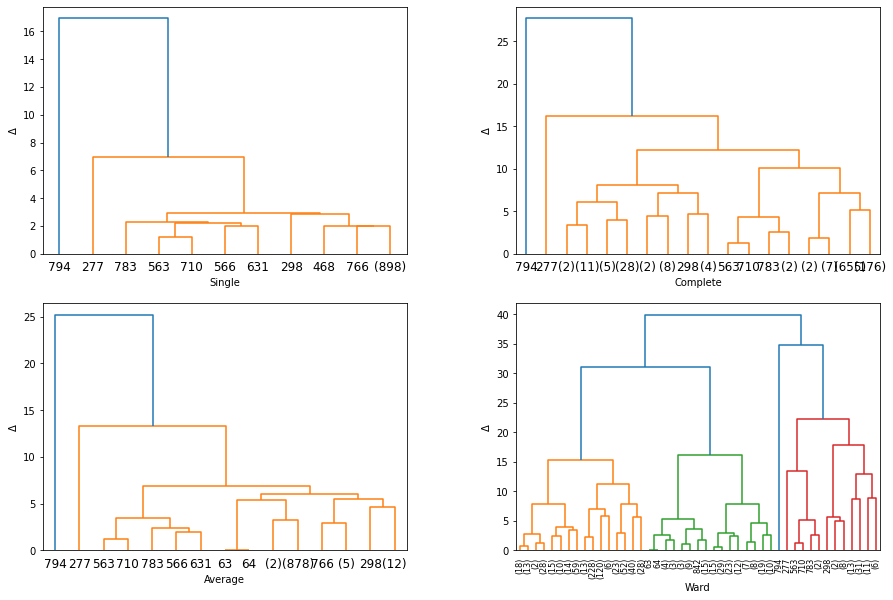

In [18]:
plot_dn(Zs, [2.2e6, 3.5e6, 3.5e6, 6e6])

array([[<AxesSubplot:xlabel='Single'>, <AxesSubplot:xlabel='Complete'>],
       [<AxesSubplot:xlabel='Average'>, <AxesSubplot:xlabel='Ward'>]],
      dtype=object)

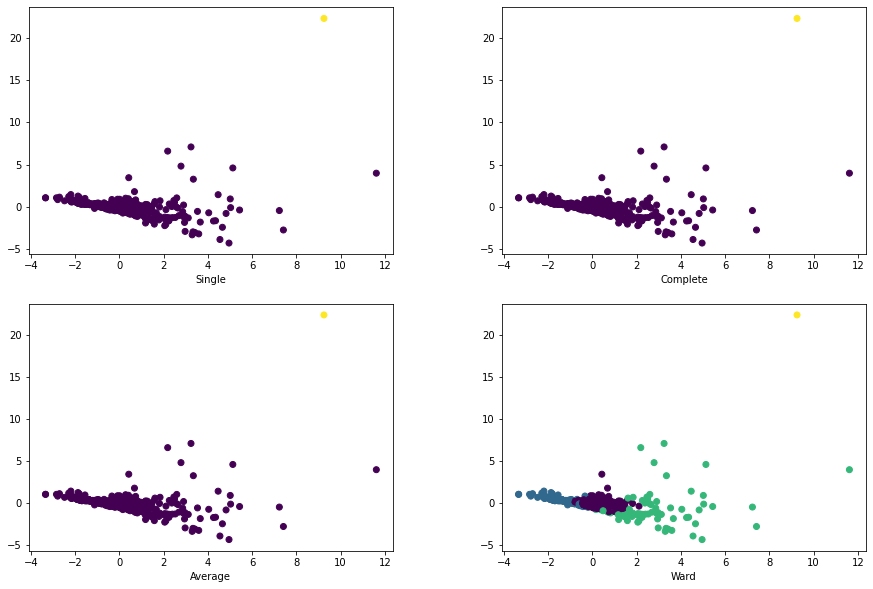

In [19]:
plot_clusters_agg(df_svd, Zs, [14, 20, 20, 25])

In [20]:
agg = AgglomerativeClustering(n_clusters=None, linkage='ward',
                              distance_threshold=25)
y_agg = agg.fit_predict(df_svd)

In [21]:
Counter(y_agg)

Counter({3: 669, 1: 160, 0: 78, 2: 1})

In [375]:
df

,id,username,name,description,created_at,location,followers_count,following_count,tweet_count,listed_count,rating
0,3248418086,MaxSupportInc,Max Support Inc. Ph,,2015-06-18T05:08:35.000Z,Pasig City,194,1653,97,0,0.0
1,1168546277535019015,iseldm10,RM🌙❄️,I'm introvert person and a bookworm,2019-09-02T15:29:29.000Z,None,363,796,62736,0,0.0
2,3106575600,mjssrclla,🌼,old soul trapped in the 21st century 🥀,2015-03-24T10:45:52.000Z,"Makati City, National Capital",479,1034,2656,0,0.0
3,203497303,protweetshake,Rj,fight for your rights through peaceful means. ...,2010-10-16T12:10:21.000Z,None,148,815,2252,0,0.0
4,325049360,lolololorainne,🥰 potanghamnida,"asian drama fan 🌸🌸🌸 ISFP, fur ate ni kikay 🐶",2011-06-27T17:13:26.000Z,Republic of the Philippines,162,1392,18176,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2945,122663985,AIMpagliflozin,Alyssa Marcelo,PTRP. Future doktora. Batch 2022. \nI love my ...,2010-03-13T13:19:41.000Z,Metro Manila,385,285,9449,10,1.0
2946,110949715,nicholettes,Polinda Usero,,2010-02-03T09:21:21.000Z,my own little crib,273,959,1469,0,0.0
2947,143413798,imagoraphobic,Jonab3ls,I am enough of an artist to draw freely upon m...,2010-05-13T11:55:40.000Z,None,306,697,3862,4,1.0
2948,14809327,Boy_Kuripot,Boy-Kuripot,"Philippine Freebies, Contests, Promos & More!",2008-05-17T09:11:28.000Z,Philippines,3677,422,2533,61,1.0


In [378]:
conn = sqlite3.connect('/mnt/processed/private/msds2023/lt9/dmw2_final_project.db')
df = (pd.read_sql("""SELECT * FROM partners""", conn)
      #.query("included==1", engine='python')
      .reset_index(drop=True)
      .drop(columns=['url', 'included'])
     )

In [379]:
df

,id,description,created_at,username,protected,name,location,followers_count,following_count,tweet_count,listed_count,rating
0,49616273,"China's national English language newspaper, u...",2009-06-22T12:41:39.000Z,globaltimesnews,0,Global Times,"Beijing, China",1880407,538,229828,0,1.0
1,293932241,Always Thankful. ask@vmgasia.co,2011-05-06T07:09:52.000Z,AlyssaValdez2,0,Alyssa Valdez,None,2258385,608,5304,445,1.0
2,42335426,"Filipina Wife, Mother of 5, Homemaker, Actress...",2009-05-25T02:48:59.000Z,mommymaricel,1,Maricel Laxa-P.,"Manila, Philippines",69898,109,6333,104,1.0
3,333955253,"Writer, moon child, cat mom, fangirl and dream...",2011-07-12T10:38:32.000Z,iamAlyloony,0,Aly 🌑🌸,PH,340964,178,136503,186,1.0
4,58155585,Curiouser and curiouser.,2009-07-19T08:20:45.000Z,KianaVee,0,Kiana V,None,90953,844,20016,72,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
910,47047335,naughtynate29@yahoo.com,2009-06-14T06:27:54.000Z,naughtynate29,0,Nate Gonzaga™,None,202774,300,88798,99,0.0
911,39453212,Welcome to the official Twitter account of GMA...,2009-05-12T07:14:09.000Z,gmanews,0,GMA News,Philippines,6481313,677,813683,8983,0.0
912,39455426,This is the official Twitter account of GMA Ne...,2009-05-12T07:37:25.000Z,gmanetwork,0,GMA Network,Philippines,1725573,709,327665,967,0.0
913,54491455,The number one entertainment website in the Ph...,2009-07-07T08:36:23.000Z,PEPalerts,0,Official PEP.ph,None,1507854,721,63691,1753,0.0


In [26]:
conn = sqlite3.connect('/mnt/processed/private/msds2023/lt9/dmw2_final_project.db')
df1 = (pd.read_sql("""SELECT * FROM followers""", conn)
      .query("included==1", engine='python')
      .reset_index(drop=True)
      .drop(columns=['url', 'included'])
     )
df1

,id,username,name,description,created_at,location,followers_count,following_count,tweet_count,listed_count,rating
0,3248418086,MaxSupportInc,Max Support Inc. Ph,,2015-06-18T05:08:35.000Z,Pasig City,194,1653,97,0,0.0
1,1168546277535019015,iseldm10,RM🌙❄️,I'm introvert person and a bookworm,2019-09-02T15:29:29.000Z,None,363,796,62736,0,0.0
2,3106575600,mjssrclla,🌼,old soul trapped in the 21st century 🥀,2015-03-24T10:45:52.000Z,"Makati City, National Capital",479,1034,2656,0,0.0
3,203497303,protweetshake,Rj,fight for your rights through peaceful means. ...,2010-10-16T12:10:21.000Z,None,148,815,2252,0,0.0
4,325049360,lolololorainne,🥰 potanghamnida,"asian drama fan 🌸🌸🌸 ISFP, fur ate ni kikay 🐶",2011-06-27T17:13:26.000Z,Republic of the Philippines,162,1392,18176,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2945,122663985,AIMpagliflozin,Alyssa Marcelo,PTRP. Future doktora. Batch 2022. \nI love my ...,2010-03-13T13:19:41.000Z,Metro Manila,385,285,9449,10,1.0
2946,110949715,nicholettes,Polinda Usero,,2010-02-03T09:21:21.000Z,my own little crib,273,959,1469,0,0.0
2947,143413798,imagoraphobic,Jonab3ls,I am enough of an artist to draw freely upon m...,2010-05-13T11:55:40.000Z,None,306,697,3862,4,1.0
2948,14809327,Boy_Kuripot,Boy-Kuripot,"Philippine Freebies, Contests, Promos & More!",2008-05-17T09:11:28.000Z,Philippines,3677,422,2533,61,1.0


In [30]:
df1[df1.id.isin(df.id.unique().tolist())]

,id,username,name,description,created_at,location,followers_count,following_count,tweet_count,listed_count,rating
918,24111037,andimanzano,Andi Manzano Reyes,aka Andi9 | host | radio dj | youtuber | wife ...,2009-03-13T02:43:06.000Z,Philippines,356591,758,28068,849,1.0
1054,21732680,candymagdotcom,Candymag.com,Every Filipina teen’s best friend since 1999 🍭...,2009-02-24T05:34:36.000Z,"Manila, Philippines",104958,1010,45548,314,0.0
1654,34275170,cosmo_ph,Cosmopolitan Philippines,Fun. Fearless. Forward. #ClickCosmo,2009-04-22T13:47:11.000Z,Philippines,100744,280,114520,402,1.0
1701,86817527,gingerconejero,Ginger Conejero Saab,📧: ginger.conejero@nbcuni.com,2009-11-01T22:29:29.000Z,"San Francisco, CA",312645,513,24466,960,1.0
1712,34664371,mariaressa,Maria Ressa,Idealist. Skeptic. Pragmatist. Journalist. Aut...,2009-04-23T16:57:05.000Z,Philippines,545102,4878,195428,2722,1.0
1717,15448383,inquirerdotnet,Inquirer,"Balanced News, Fearless Views. https://t.co/Au...",2008-07-16T00:36:41.000Z,Makati City,3725443,1811,1149704,6503,1.0
2124,171553344,AngeliPV,Angeli Pangilinan Valenciano,https://t.co/awALtQPFwg.I love my family& I li...,2010-07-27T16:30:21.000Z,"Manila, Philippines",301039,4242,125121,144,1.0
2150,262657733,TheFreemanNews,The Freeman,Cebu's news source since 1919 and a member of ...,2011-03-08T13:57:02.000Z,"Cebu, Philippines",51926,1040,104078,208,1.0
2199,28313920,jenniepperson,Jenni Epperson,Always Sunday Co-founder | String (IG: @shopst...,2009-04-02T10:23:39.000Z,Live Style,72456,601,33601,404,1.0
2270,244746802,machavelli7,MACHAVELLI MEDICI,B.A. Philosophy. Ancient historian WBAU Radio....,2011-01-30T01:43:14.000Z,NYC,935119,846986,2373,2274,1.0


In [28]:
len(df.id.unique().tolist())

2950